## Importing Libraries

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from Model_Parent import *
from Model_Parent_2 import *

## Importing Data

In [17]:
df = pd.read_csv("../cleaned_data/CCPP.csv", index_col=0)


df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


## Checking Data

<AxesSubplot:>

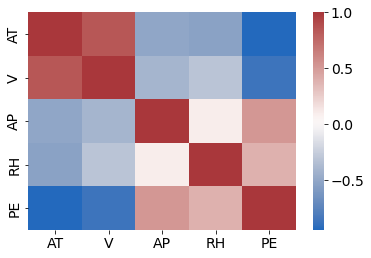

In [18]:
# Check to make sure that no columns have perfect colinearity

corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat, cmap='vlag')

## Scaling Data

In [19]:
# Storing old columns names
df_col_names = list(df.columns)

# Scaling data by min and max in the range of 0 to 1
scaler = MinMaxScaler(feature_range = [0, 1])
tmp = scaler.fit_transform(df)

# Converting scaled values back into dataframe
df = pd.DataFrame(tmp, columns=df_col_names)

df

,AT,V,AP,RH,PE
0,0.372521,0.291815,0.771591,0.638204,0.569536
1,0.662040,0.669039,0.671863,0.449330,0.319338
2,0.093484,0.249822,0.476862,0.892493,0.904636
3,0.539660,0.568683,0.429349,0.684718,0.347285
4,0.255241,0.216014,0.404355,0.952547,0.710464
...,...,...,...,...,...
9563,0.420397,0.432918,0.522643,0.877212,0.526755
9564,0.322380,0.245907,0.761693,0.552547,0.653775
9565,0.835977,0.871352,0.495669,0.146381,0.123311
9566,0.642210,0.784520,0.518931,0.493700,0.205033


## Breaking Data in X and y

In [20]:
X = df.iloc[:,:-1]

In [21]:
y = df.iloc[:,-1]

# Generating Models

In [ ]:
# Imports to build layered neural nets
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Defining number of folds in cross validation (kfolds method)
cv_folds = 5

# Defining number of epochs
epo = 10

# Defining batch size
bs = 1000

## 2 Layer Neural Networks

### Sigmoid Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 2 values in the list are neurons of first 2 layers.
# The last value corresponds to the output layer
nur_list = [10, 5, 1]

# a_func is the activation function of choice
a_func = 'sigmoid'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### Tanh Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 2 values in the list are neurons of first 2 layers.
# The last value corresponds to the output layer
nur_list = [10, 5, 1]

# a_func is the activation function of choice
a_func = 'tanh'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### ReLU Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 2 values in the list are neurons of first 2 layers.
# The last value corresponds to the output layer
nur_list = [10, 5, 1]

# a_func is the activation function of choice
a_func = 'relu'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

## 3 Layer Neural Networks

### Sigmoid Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 3 values in the list are neurons of first 3 layers.
# The last value corresponds to the output layer
nur_list = [25, 10, 5, 1]

# a_func is the activation function of choice
a_func = 'sigmoid'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### Tanh Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 3 values in the list are neurons of first 3 layers.
# The last value corresponds to the output layer
nur_list = [25, 10, 5, 1]

# a_func is the activation function of choice
a_func = 'tanh'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### ReLU Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 3 values in the list are neurons of first 3 layers.
# The last value corresponds to the output layer
nur_list = [25, 10, 5, 1]

# a_func is the activation function of choice
a_func = 'relu'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

## 5 Layer Neural Networks

### Sigmoid Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 5 values in the list are neurons of first 5 layers.
# The last value corresponds to the output layer
nur_list = [500, 100, 25, 10, 5, 1]

# a_func is the activation function of choice
a_func = 'sigmoid'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### Tanh Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 5 values in the list are neurons of first 5 layers.
# The last value corresponds to the output layer
nur_list = [500, 100, 25, 10, 5, 1]

# a_func is the activation function of choice
a_func = 'tanh'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

### ReLU Activation Function

In [ ]:
# nur_list is a list of number of neurons for each layer.
# In this case the first 5 values in the list are neurons of first 5 layers.
# The last value corresponds to the output layer
nur_list = [500, 100, 25, 10, 5, 1]

# a_func is the activation function of choice
a_func = 'relu'

# opt is the optimazation function of choice
opt = 'adam'

# loss_ is the loss funciton of choice
loss_ = 'mean_squared_error'

In [ ]:
nnCrossValidation(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)

In [ ]:
nnForwardSelection(X, y, cv_folds, epo, bs, nur_list, a_func, opt, loss_)